In [95]:
help(qml.qchem.Molecule)

Help on class Molecule in module pennylane.qchem.molecule:

class Molecule(builtins.object)
 |  Molecule(symbols, coordinates, charge=0, mult=1, basis_name='sto-3g', name='molecule', load_data=False, l=None, alpha=None, coeff=None, normalize=True, unit='bohr')
 |  
 |  Create a molecule object that stores molecular information and default basis set parameters.
 |  
 |  The molecule object can be passed to functions that perform a Hartree-Fock calculation.
 |  
 |  Args:
 |      symbols (list[str]): Symbols of the atomic species in the molecule. Currently, atoms with
 |          atomic numbers 1-10 are supported.
 |      coordinates (array[float]): 1D array with the atomic positions in Cartesian coordinates. The
 |          coordinates must be given in atomic units and the size of the array should be ``3*N``
 |          where ``N`` is the number of atoms.
 |      charge (int): net charge of the molecule
 |      mult (int): Spin multiplicity :math:`\mathrm{mult}=N_\mathrm{unpaired} + 1` 

In [109]:
from jax import numpy as np
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)
symbols = ["He", "H"]
coordinates = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.9]])# coordinates of both Helium and Hydrogen nuclie
charge = 1
# so basically we are going to find ground state of Helim-Hydride using Variational method (VQE) 

In [110]:
import pennylane as qml

molecule = qml.qchem.Molecule(symbols, coordinates, charge)
H, qubits = qml.qchem.molecular_hamiltonian(molecule)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H) # here we assume atoms having only two state i.e. ground and excited state hence we can represent it as 4 cross 4 Hamiltonian. 
print(molecule)

Number of qubits =  4
The Hamiltonian is  -0.7649658352667643 * I(0) + 0.8612517144559696 * Z(0) + 0.03811122174621449 * (Y(0) @ Z(1) @ Y(2)) + 0.03811122174621449 * (X(0) @ Z(1) @ X(2)) + 0.07406212203795781 * Z(2) + 0.14944746147022825 * (Z(0) @ Z(2)) + 0.8612517144559694 * Z(1) + 0.24408144381862154 * (Z(0) @ Z(1)) + 0.04338564606277569 * (Y(0) @ Y(2)) + 0.04338564606277569 * (X(0) @ X(2)) + 0.038111221746214494 * (Y(1) @ Z(2) @ Y(3)) + 0.04338564606277569 * (Z(0) @ Y(1) @ Z(2) @ Y(3)) + 0.038111221746214494 * (X(1) @ Z(2) @ X(3)) + 0.04338564606277569 * (Z(0) @ X(1) @ Z(2) @ X(3)) + 0.0415685604611815 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.0415685604611815 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.0415685604611815 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.0415685604611815 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.07406212203795781 * Z(3) + 0.19101602193140976 * (Z(0) @ Z(3)) + 0.005274424194929801 * (Y(0) @ Z(1) @ Y(2) @ Z(3)) + 0.005274424194929801 * (X(0) @ Z(1) @ X(2) @ Z(3)) + 0.14944746147022825 * (Z(1)

In [111]:
# pip install aiohttp fsspec h5py

In [112]:
#help(qml.data.load)

In [113]:
dataset = qml.data.load('qchem', molname="HeH+")[0] # this is the data we are going to use for our model
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
#print(H, qubits)

In [114]:
dev = qml.device("default.qubit", wires=qubits)

In [115]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [116]:
# so using QPU we will first caculate the expectation value of Hamiltonian and then later on we optimize(in our case minimize) <H>=<psi|h|psi>/<psi|psi>
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [117]:
def cost_fn(param):
    return circuit(param, wires=range(qubits)) 

In [118]:
import optax

max_iterations = 100
conv_tol = 1e-15

opt = optax.sgd(learning_rate=0.5) 

In [119]:
# !pip install optax

In [120]:
theta = np.array(-10.0) #theta is the array of parameters that defines the expectation value and we will find theta that will minimise <H>. 

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2]) 
    # as the the ground state energy started converging the difference will reduce and tends toward threshold conv_tol.

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.16303070 Ha
Step = 2,  Energy = -2.32879352 Ha
Step = 4,  Energy = -2.81978548 Ha
Step = 6,  Energy = -2.85012216 Ha
Step = 8,  Energy = -2.85118648 Ha
Step = 10,  Energy = -2.85122259 Ha
Step = 12,  Energy = -2.85122382 Ha
Step = 14,  Energy = -2.85122386 Ha
Step = 16,  Energy = -2.85122386 Ha
Step = 18,  Energy = -2.85122386 Ha
Step = 20,  Energy = -2.85122386 Ha
Step = 22,  Energy = -2.85122386 Ha

Final value of the ground-state energy = -2.85122386 Ha

Optimal value of the circuit parameter = -12.4387


In [92]:
# as we can see the ground state energy of H-He+ is matching with what we have in paper i.e -2.86. Finding the ground state energy using variational method

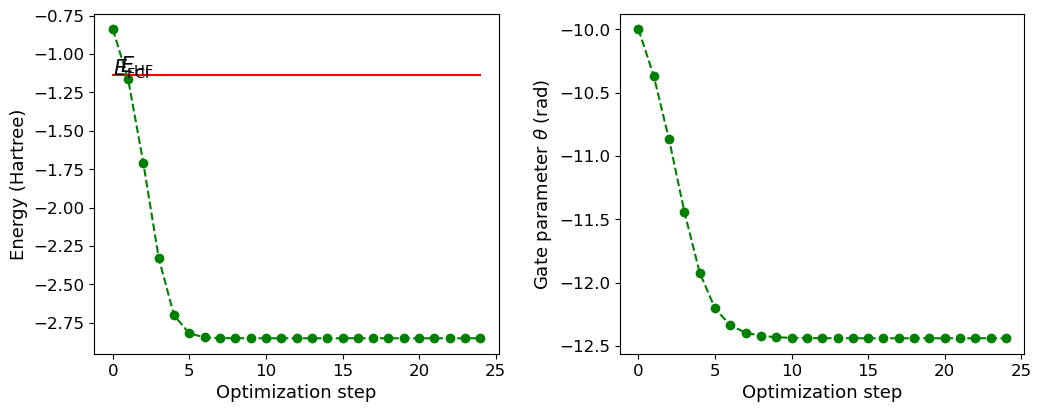

In [121]:
# So we have data for both parameter as well as the ground state energy, now we are going plot them and see how it is conversing.
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()